# IMAGE ANALYSIS

In [1]:
import os
import sys
import torch
import random
import tifffile
import numpy as np
import matplotlib.pyplot as plt


# Get the parent directory (project root) and add it to sys.path
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.append(root_dir)


from utils.utils import compute_global_mean_std, tonemap_gamma_correct
from renderer.SceneRenderer import SceneRenderer

/data/transient/cxp431/miniconda3/envs/mcrt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


# STANDARDISATION ONLY
- Global: Stable but ignores image-specific details.
- Per image: Captures individual contrast but loses global info.
- Per patch: Handles local variation but may cause inconsistency.
- Per batch: best one yet !!!

*NOTE:* still issue with very high dynamic ranges HDR!

In [17]:
root_dir = "../output/"  # <- set your root path here

mean, std = compute_global_mean_std(root_dir)

print("Global Statistics (Box-Cox Transformed)")
print(f"Mean: {[round(x.item(), 4) for x in mean.view(-1)]}")
print(f"Std : {[round(x.item(), 4) for x in std.view(-1)]}")

Global Statistics (Box-Cox Transformed)
Mean: [1.2951, 1.0415, 0.843]
Std : [8.4115, 6.7185, 5.3981]


# LOG NORMALISATION + STANDARDISATION

# Box-Cox Transform and Standardization

The **Box-Cox transform** stabilizes variance and makes data more Gaussian-like:

$$
y(\lambda) = 
\begin{cases}
\dfrac{x^\lambda - 1}{\lambda} & \lambda \neq 0 \\
\log(x) & \lambda = 0
\end{cases}
$$

where $x > 0$ and $\lambda$ controls the transformation shape.

After that, **standardization** normalizes data to zero mean and unit variance:

$$
z = \dfrac{y - \mu}{\sigma}
$$

with $\mu$ and $\sigma$ being the mean and std of $y$.

These can be reverted to get back the original image.

# Albedo Normalisation

Radiance (RGB) = Albedo * Shading ---> Shading = Radiance (RGB) / Albedo + eps

where: 
- **radiance** (RGB) = amount of light
- **albedo** = true color of a surface/how much light it reflects
- **shading** = how light/shadow fall ona surface

Albedo Normalisation is more consistent across different scenes but reverted image may be darker than the original one.

In [18]:
import os
import numpy as np
import mitsuba as mi
import matplotlib.pyplot as plt

def compute_channel_stats(img, name="Image"):
    """
    Computes and prints per-channel mean and std for a given image.
    Assumes img shape is (H, W, C)
    """
    print(f"\n{name} Statistics:")
    for i, color in enumerate(['R', 'G', 'B']):
        channel = img[..., i]
        print(f"  {color}: mean={channel.mean():.4f}, std={channel.std():.4f}")

def safe_divide(numerator, denominator, eps=1e-4):
    return numerator / np.clip(denominator, eps, None)

In [ ]:
def recover_scene_with_albedo(scene_folder, spp=16):
    mi.set_variant("llvm_ad_rgb")

    scene_path = os.path.join(scene_folder, "scene.xml")
    scene = mi.load_file(scene_path)

    # Define AOV integrator that includes albedo
    integrator = mi.load_dict({
        'type': 'aov',
        'aovs': 'aa:albedo',
        'my_image': {
            'type': 'path'
        }
    })

    # Render the full image (RGB + AOVs)
    img_full = mi.render(scene, spp=spp, integrator=integrator)
    img_full = np.array(img_full)

    # The output shape is (H, W, N_channels)
    _, _, C = img_full.shape

    if C < 6:
        raise RuntimeError(f"Expected at least 6 channels (RGB + albedo), got {C}.")

    # Split RGB and albedo
    img_rgb = img_full[..., 0:3]
    img_albedo = img_full[..., 3:6]

    # Clamp to avoid NaNs / divisions by zero
    # img_rgb = np.clip(img_rgb, 0, 1)
    # img_albedo = np.clip(img_albedo, 1e-4, 1.0)

    # Reconstruct shading: RGB = Albedo * Shading → Shading ≈ RGB / Albedo
    img_shading = safe_divide(img_rgb, img_albedo)
    # Recover radiance from shading and albedo
    img_recovered = img_shading * img_albedo

    # Statistics
    compute_channel_stats(img_rgb, "Rendered Radiance")
    compute_channel_stats(img_albedo, "Albedo")
    compute_channel_stats(img_shading, "Shading (Radiance / Albedo)")
    compute_channel_stats(img_recovered, "Recovered Radiance")

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(tonemap_gamma_correct(img_rgb))
    axes[0].set_title("Rendered Radiance (Path)")
    axes[1].imshow(img_albedo)
    axes[1].set_title("AOV: Albedo")
    axes[2].imshow(tonemap_gamma_correct(img_shading))
    axes[2].set_title("Approx. Shading (Radiance / Albedo)")
    axes[3].imshow(tonemap_gamma_correct(img_recovered))
    axes[3].set_title("Recovered Radiance (Shading * Albedo)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Rendered Radiance Statistics:
  R: mean=2.4407, std=10.5720
  G: mean=1.4346, std=6.1076
  B: mean=0.6218, std=2.3781

Albedo Statistics:
  R: mean=0.4503, std=0.3034
  G: mean=0.3934, std=0.3341
  B: mean=0.3658, std=0.3532

Shading (Radiance / Albedo) Statistics:
  R: mean=19155.4434, std=103342.6406
  G: mean=10920.6826, std=59663.8750
  B: mean=4336.4487, std=23244.9551

Recovered Radiance Statistics:
  R: mean=0.5255, std=2.6422
  G: mean=0.3428, std=1.5664
  B: mean=0.1886, std=0.6444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..33.995857].


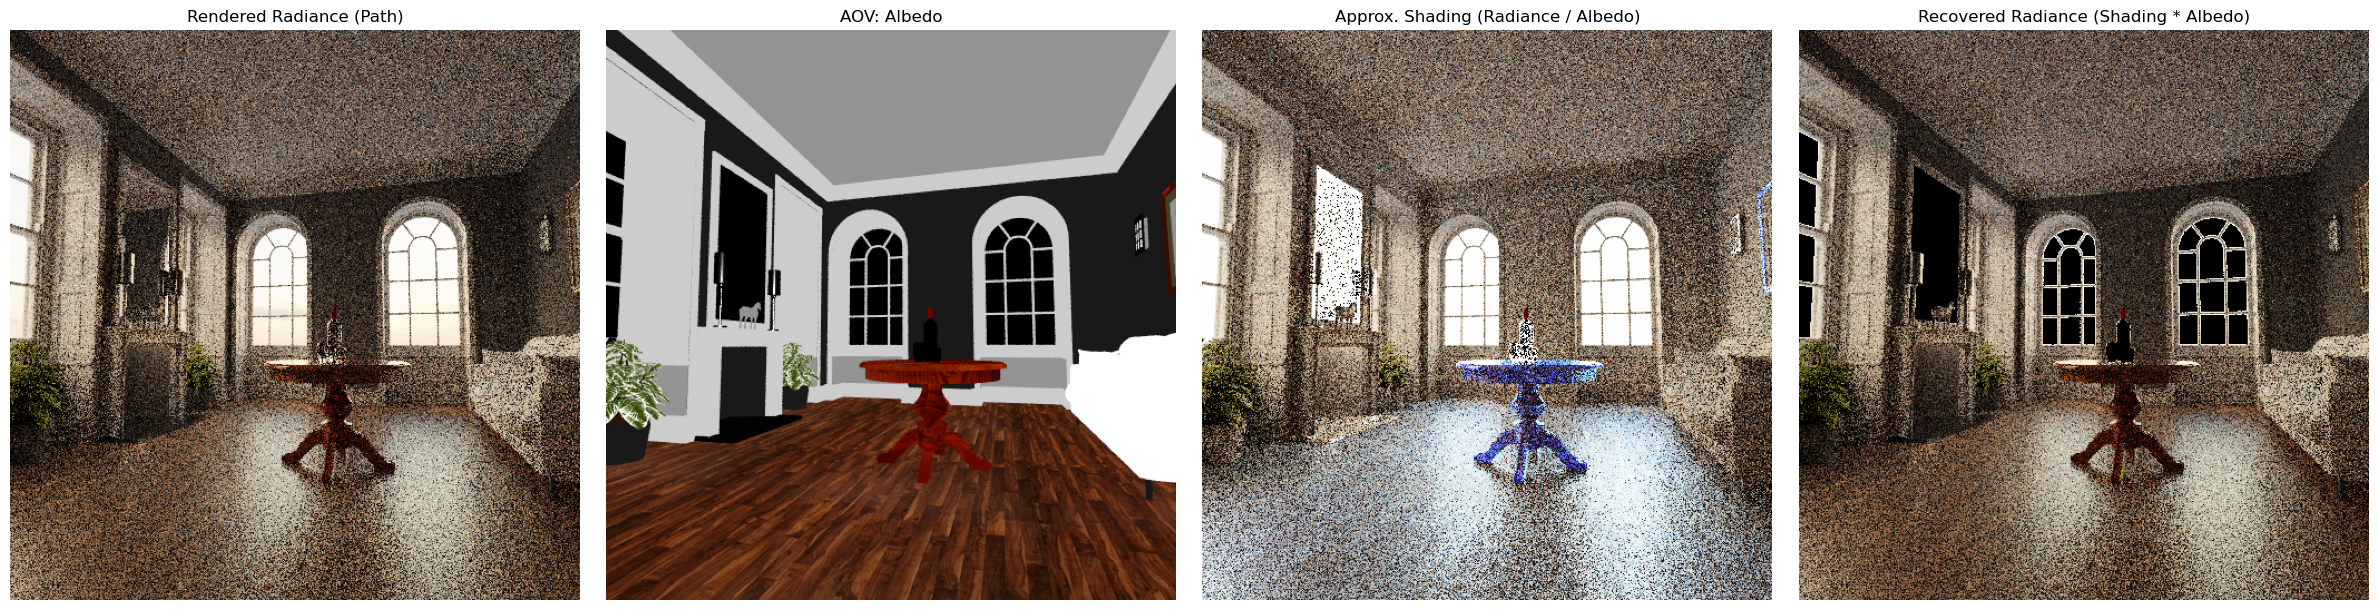

In [15]:
recover_scene_with_albedo("../data/living-room/", spp=16)

In [26]:
def print_stats(name, data):
    """
    Prints per-channel statistics (mean, std, min, max) for image data.

    Args:
        name (str): Label to print.
        data (np.ndarray or torch.Tensor): Image data of shape (H, W, C) or (H, W).
    """
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()

    if data.ndim == 2:  # Grayscale image, shape: (H, W)
        flat = data.reshape(-1)
        print(f"\n{name} Stats (Gray):")
        print(f"  Mean : {flat.mean():.4f}")
        print(f"  Std  : {flat.std():.4f}")
        print(f"  Min  : {flat.min():.4f}")
        print(f"  Max  : {flat.max():.4f}")

    elif data.ndim == 3 and data.shape[2] == 3:  # RGB image, shape: (H, W, 3)
        flat = data.reshape(-1, 3)
        print(f"\n{name} Stats (R, G, B):")
        print(f"  Mean : {flat.mean(axis=0)}")
        print(f"  Std  : {flat.std(axis=0)}")
        print(f"  Min  : {flat.min(axis=0)}")
        print(f"  Max  : {flat.max(axis=0)}")

    else:
        raise ValueError(f"Unsupported shape {data.shape}. Expected (H, W) or (H, W, 3).")

In [27]:
import torch

def albedo_to_grayscale(albedo: torch.Tensor) -> torch.Tensor:
    """
    Convert a 3-channel RGB albedo tensor to grayscale using CCIR 601 weights.
    
    Args:
        albedo (torch.Tensor): Tensor of shape (3, H, W), assumed to be RGB.

    Returns:
        torch.Tensor: Grayscale albedo tensor of shape (1, H, W).
    """
    albedo = torch.from_numpy(albedo).permute(2, 0, 1).float() 
    assert albedo.shape[0] == 3, f"Expected 3-channel input, got shape {albedo.shape}"
    
    # CCIR 601 luminance weights
    weights = torch.tensor([0.2989, 0.5870, 0.1140], dtype=albedo.dtype, device=albedo.device).view(3, 1, 1)
    
    grayscale = (albedo * weights).sum(dim=0, keepdim=True)  # Result: (1, H, W)
    
    return grayscale.squeeze(0)


In [32]:
import mitsuba as mi
mi.set_variant("scalar_rgb")

def render_scene_aov(scene_folder, spp=16):
    scene_path = os.path.join(scene_folder, "scene.xml")
    renderer = SceneRenderer(scene_path, debug=False)

    # Split RGB and albedo
    img_albedo = renderer.render_albedo_image()
    img_normal = renderer.render_normal_image()

    bw_albedo = albedo_to_grayscale(img_albedo)

    print("Albedo Shape: ", img_albedo.shape)
    print("BW ALbedo Shape: ", bw_albedo.shape)
    print("Normal Shape: ", img_normal.shape)

    print_stats("Albedo RGB", img_albedo)
    print_stats("Albedo BW", bw_albedo)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    axes[0].imshow(img_albedo)
    axes[0].set_title("AOV: Albedo")
    axes[1].imshow(bw_albedo, cmap='gray')
    axes[1].set_title("AOV: Albedo BW")
    axes[2].imshow(img_normal)
    axes[2].set_title("AOV: Normal")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Using.. scalar_rgb (for albedo)
Using.. scalar_rgb (for normals)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Albedo Shape:  (512, 512, 3)
BW ALbedo Shape:  torch.Size([512, 512])
Normal Shape:  (512, 512, 3)

Albedo RGB Stats (R, G, B):
  Mean : [0.7683141 0.7374408 0.7506188]
  Std  : [0.9747293 0.9665523 0.977661 ]
  Min  : [0. 0. 0.]
  Max  : [17.418144 17.225899 17.246622]

Albedo BW Stats (Gray):
  Mean : 0.7480
  Std  : 0.9684
  Min  : 0.0000
  Max  : 17.2840


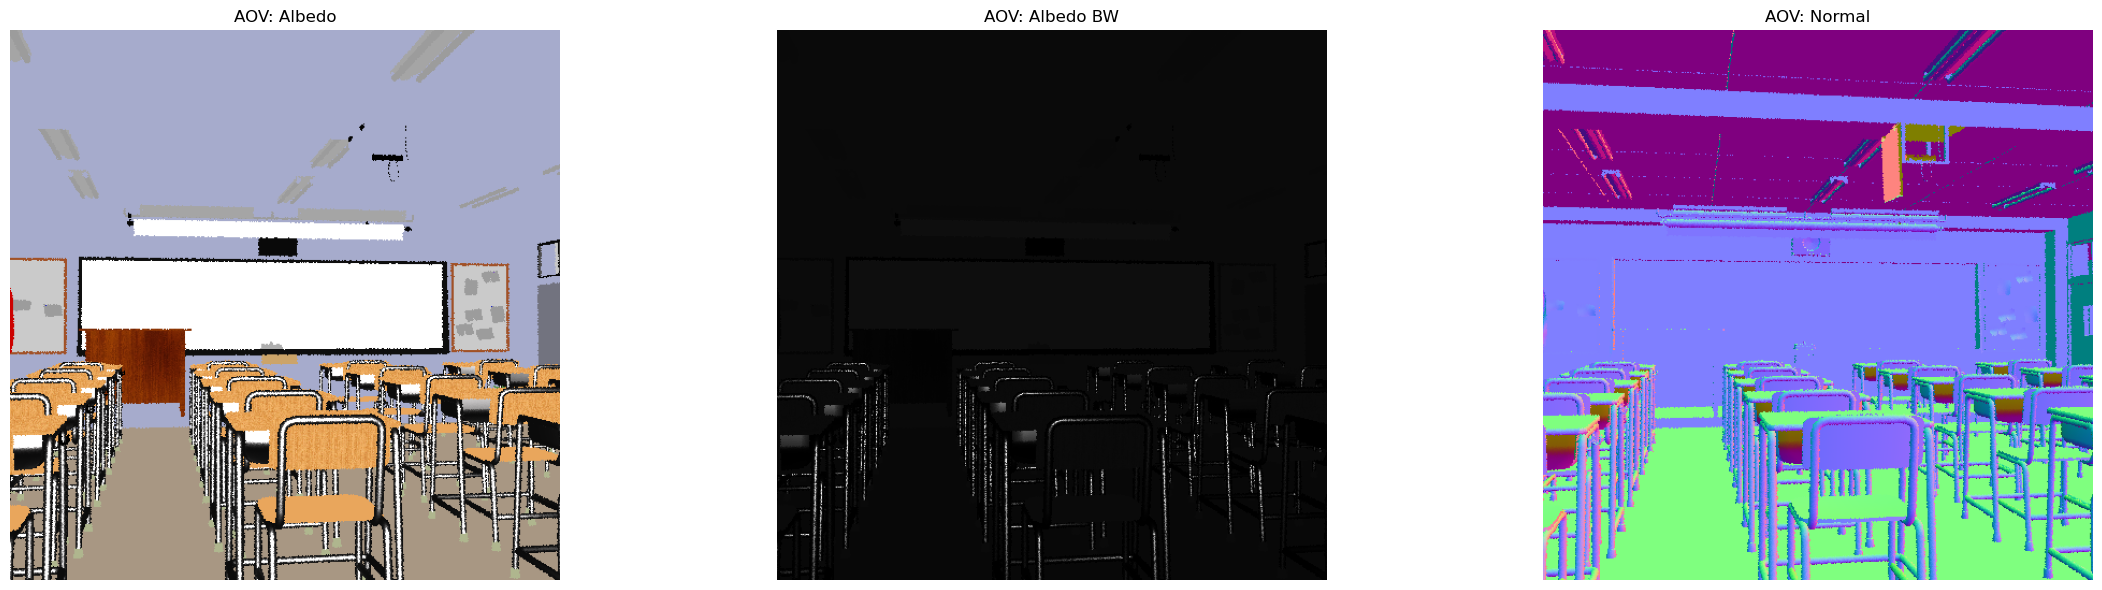

In [33]:
render_scene_aov("../data/classroom/", spp=16)

# Utils Functions to Save Plots !!!

In [ ]:
import os
import math
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def process_3scene(folder_path):
    scene_name = os.path.basename(folder_path)
    files = os.listdir(folder_path)

    path_4500 = next((f for f in files if "spp4500" in f), None)
    path_32   = next((f for f in files if "spp32.tiff" in f and "1x32" not in f), None)
    path_1x32 = next((f for f in files if "spp1x32" in f), None)

    if not all([path_4500, path_32, path_1x32]):
        print(f"Missing files in {scene_name}, skipping...")
        return None

    # Load raw images
    img_clean = tifffile.imread(os.path.join(folder_path, path_4500)).astype(np.float32)
    img_noisy = tifffile.imread(os.path.join(folder_path, path_32)).astype(np.float32)
    img_1spp_stack = tifffile.imread(os.path.join(folder_path, path_1x32)).astype(np.float32)
    img_1spp = img_1spp_stack[0]  # first frame

    # Helper function to save a single image with matplotlib (no axes, no padding)
    def save_image(image, path):
        dpi = 100
        fig_width = image.shape[1] / dpi
        fig_height = image.shape[0] / dpi

        fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi, frameon=False)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.imshow(np.clip(image, 0, 1))
        ax.axis('off')
        plt.savefig(path, dpi=dpi, pad_inches=0)
        plt.close()

    # Save each separately
    save_image(img_1spp, os.path.join(folder_path, f"{scene_name}_1spp.png"))
    save_image(img_noisy, os.path.join(folder_path, f"{scene_name}_32spp.png"))
    save_image(img_clean, os.path.join(folder_path, f"{scene_name}_4500spp.png"))

    return img_clean, scene_name

def render_4500_grid(parent_dir, save_prefix="grid"):
    scene_dirs = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir)
                  if os.path.isdir(os.path.join(parent_dir, d))]

    images = []

    for scene_path in scene_dirs:
        files = os.listdir(scene_path)
        path_4500 = next((f for f in files if "spp4500" in f), None)

        if path_4500 is None:
            print(f"Missing 4500spp in {os.path.basename(scene_path)}, skipping...")
            continue

        img = tifffile.imread(os.path.join(scene_path, path_4500)).astype(np.float32)
        images.append(np.clip(img, 0, 1))

    if not images:
        print("No valid 4500spp images found.")
        return

    num_images = len(images)
    images_per_grid = 9
    num_grids = math.ceil(num_images / images_per_grid)

    for grid_idx in range(num_grids):
        fig = plt.figure(figsize=(9, 9))  # Adjust size if needed
        grid = plt.GridSpec(3, 3, wspace=0, hspace=0)

        for i in range(9):
            img_idx = grid_idx * images_per_grid + i
            ax = fig.add_subplot(grid[i // 3, i % 3])
            ax.axis("off")

            if img_idx < num_images:
                ax.imshow(images[img_idx])
            else:
                ax.imshow(np.ones_like(images[0]))  # white placeholder

        save_path = f"{save_prefix}_{grid_idx}.png"
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Saved: {save_path}")
        break


In [ ]:
render_4500_grid("../output/")

In [ ]:
process_3scene("../output/kitchen/")

# Tone Mapping & Gamma Correction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00071816763..125.0].


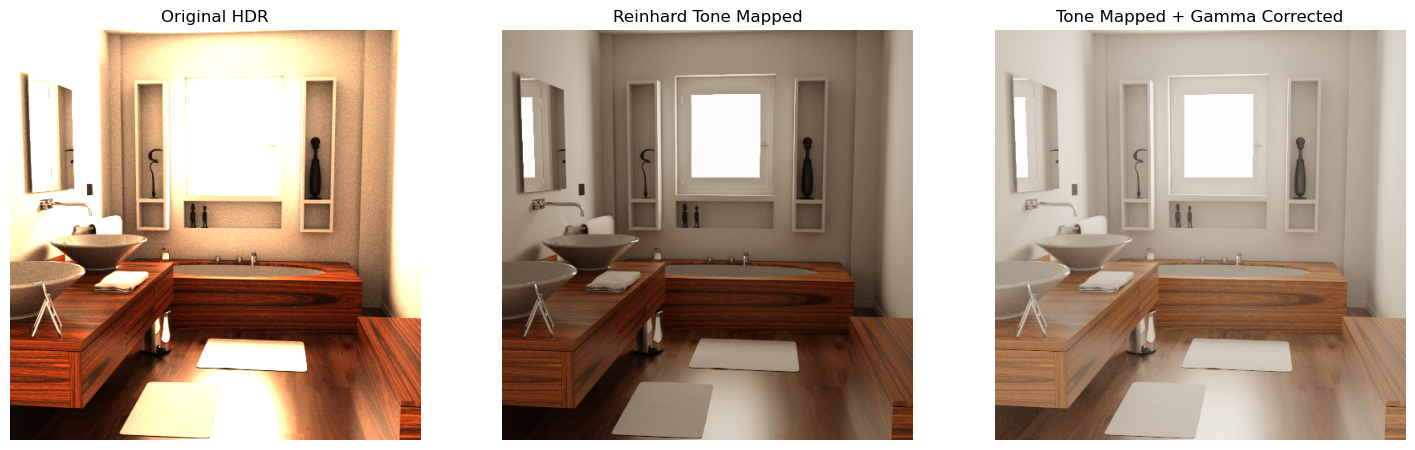

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

# Load HDR .tiff
img = tifffile.imread("../output/bathroom2/bathroom2_scene_spp4500.tiff").astype(np.float32)  # shape: (H, W, 3)

# Reinhard tone mapping
img_tone = img / (1.0 + img)

# Gamma correction for display
img_display = np.power(np.clip(img_tone, 0, 1), 1/2.2)

# For the original HDR image, normalize for display only (clipping won't be exact but for visualization)
img_orig_norm = img / (np.max(img) + 1e-8)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img)
axs[0].set_title('Original HDR')
axs[0].axis('off')

axs[1].imshow(img_tone)
axs[1].set_title('Reinhard Tone Mapped')
axs[1].axis('off')

axs[2].imshow(img_display)
axs[2].set_title('Tone Mapped + Gamma Corrected')
axs[2].axis('off')

plt.show()

# Plot EXR files

In [ ]:
# TODO: to be implemented

# Model Analysis

In [2]:
import torch
state_dict = torch.load("../results/n2n/2025-07-28_noise2noise_mean_binsimg_ep300_mse_aov.pth", map_location='cpu')

for key, value in state_dict.items():
    print(f"{key}: {value.shape}")

enc_conv01.0.block.0.weight: torch.Size([48, 9, 3, 3])
enc_conv01.1.block.0.weight: torch.Size([48, 48, 3, 3])
enc_conv2.0.block.0.weight: torch.Size([48, 48, 3, 3])
enc_conv3.0.block.0.weight: torch.Size([48, 48, 3, 3])
enc_conv4.0.block.0.weight: torch.Size([48, 48, 3, 3])
enc_conv56.0.block.0.weight: torch.Size([48, 48, 3, 3])
enc_conv56.2.block.0.weight: torch.Size([48, 48, 3, 3])
dec_conv5ab.0.block.0.weight: torch.Size([96, 96, 3, 3])
dec_conv5ab.1.block.0.weight: torch.Size([96, 96, 3, 3])
dec_conv4ab.0.block.0.weight: torch.Size([96, 144, 3, 3])
dec_conv4ab.1.block.0.weight: torch.Size([96, 96, 3, 3])
dec_conv3ab.0.block.0.weight: torch.Size([96, 144, 3, 3])
dec_conv3ab.1.block.0.weight: torch.Size([96, 96, 3, 3])
dec_conv2ab.0.block.0.weight: torch.Size([96, 144, 3, 3])
dec_conv2ab.1.block.0.weight: torch.Size([96, 96, 3, 3])
dec_conv1abc.0.block.0.weight: torch.Size([64, 105, 3, 3])
dec_conv1abc.1.block.0.weight: torch.Size([32, 64, 3, 3])
dec_conv1abc.2.weight: torch.Size([3

# Direct vs. Path Tracing Integrators in Mitsuba

In [9]:
def render_scene_direct_vs_path(scene_folder, spp=16):
    scene_path = os.path.join(scene_folder, "scene.xml")
    renderer = SceneRenderer(scene_path, debug=False)

    # Split RGB and albedo
    img_direct = renderer.generate_samples_from_scene_direct(seed=42, spp=spp)
    img_path = renderer.generate_samples_from_scene(seed=42, spp=spp)

    print("Image Direct Shape: ", img_direct.shape)
    print("Image Path Shape: ", img_path.shape)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    axes[0].imshow(img_direct)
    axes[0].set_title("Direct Integrator")
    axes[1].imshow(img_path)
    axes[1].set_title("Path Tracing Integrator")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Using.. scalar_rgb
Using.. scalar_rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9788558].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.4450612].


Image Direct Shape:  (512, 512, 3)
Image Path Shape:  (512, 512, 3)


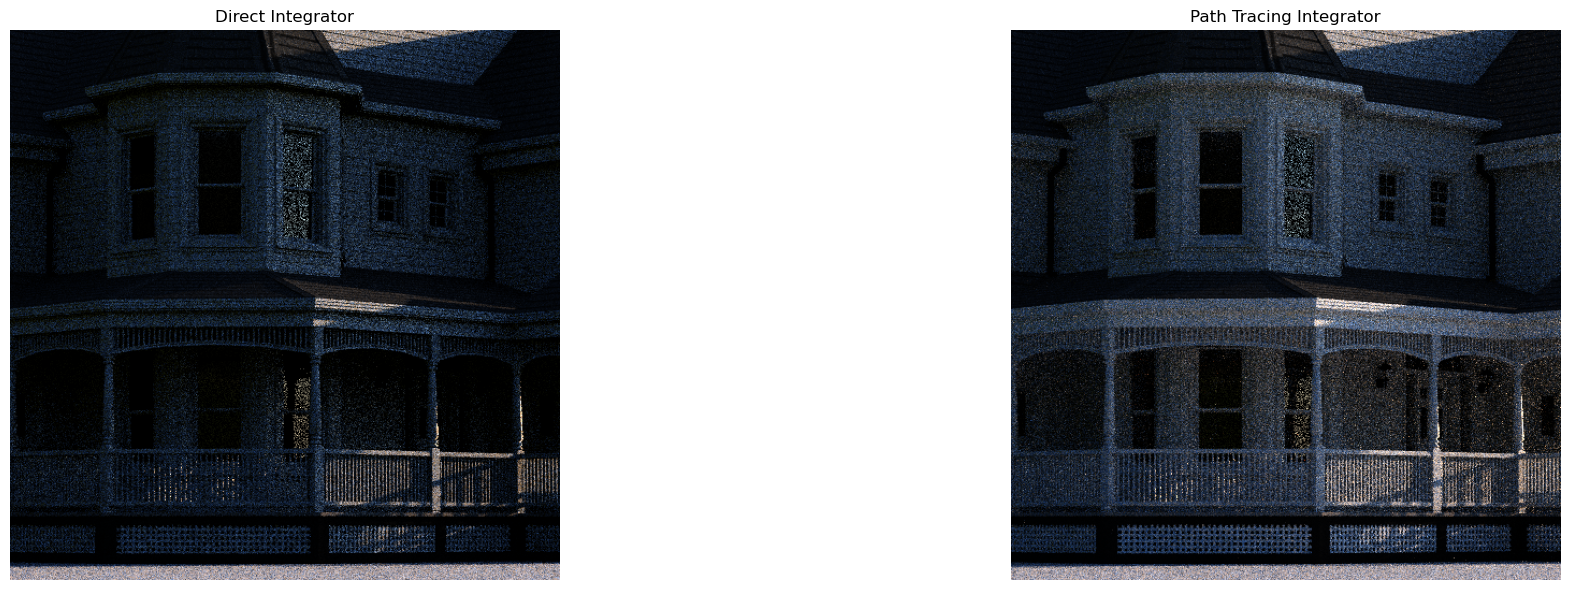

In [10]:
render_scene_direct_vs_path("../data/house/", spp=8)

# Image Statistics Summary

In [2]:
SHOW_HISTOGRAMS = False
BASE_DIR = "../output"

In [3]:
FILE_SUFFIXES = {
    "1spp_stack": "spp1x32.tiff",
    "32spp": "spp32.tiff",
    "clean": "spp4500.tiff",
    "albedo": "albedo.tiff",
    "normal": "normal.tiff"
}

def describe_image(name, img):
    img = np.array(img)
    print(f"\n{name}:")
    print(f"  Shape: {img.shape}")
    print(f"  Dtype: {img.dtype}")
    print(f"  Global Min: {img.min():.4f}")
    print(f"  Global Max: {img.max():.4f}")
    print(f"  Global Mean: {img.mean():.4f}")
    print(f"  Global Std: {img.std():.4f}")

    if img.ndim >= 3 and img.shape[-1] == 3:
        channel_names = ['R', 'G', 'B']
        for c in range(3):
            ch = img[..., c]
            print(f"    Channel {channel_names[c]} — min: {ch.min():.4f}, max: {ch.max():.4f}, "
                  f"mean: {ch.mean():.4f}, std: {ch.std():.4f}")

    if SHOW_HISTOGRAMS:
        plt.figure(figsize=(8, 4))
        if img.ndim == 3 and img.shape[-1] == 3:
            for i, color in enumerate(['r', 'g', 'b']):
                plt.hist(img[..., i].flatten(), bins=200, log=True, alpha=0.5, color=color, label=color.upper())
            plt.legend()
        else:
            plt.hist(img.flatten(), bins=200, log=True, color='blue', alpha=0.7)

        plt.title(f"Histogram: {name}")
        plt.xlabel("Pixel Value")
        plt.ylabel("Log Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def find_file_by_suffix(scene_dir, suffix):
    for f in os.listdir(scene_dir):
        if f.endswith(suffix):
            return os.path.join(scene_dir, f)
    return None

def process_scene(scene_path):
    print(f"\n=== Processing Scene: {scene_path} ===")
    for label, suffix in FILE_SUFFIXES.items():
        file_path = find_file_by_suffix(scene_path, suffix)
        if not file_path:
            print(f"[Warning] File ending with '{suffix}' not found in {scene_path}")
            continue
        try:
            img = tifffile.imread(file_path)
            describe_image(label, img)
        except Exception as e:
            print(f"[Error] Could not read {file_path}: {e}")


In [4]:
for scene_name in sorted(os.listdir(BASE_DIR)):
    scene_path = os.path.join(BASE_DIR, scene_name)
    if os.path.isdir(scene_path):
        process_scene(scene_path)


=== Processing Scene: ../output/bathroom ===

1spp_stack:
  Shape: (32, 512, 512, 3)
  Dtype: float32
  Global Min: 0.0000
  Global Max: 79.3577
  Global Mean: 2.5678
  Global Std: 7.8321
    Channel R — min: 0.0000, max: 75.1600, mean: 2.5806, std: 7.8298
    Channel G — min: 0.0000, max: 75.1600, mean: 2.5627, std: 7.8297
    Channel B — min: 0.0000, max: 79.3577, mean: 2.5602, std: 7.8367

32spp:
  Shape: (512, 512, 3)
  Dtype: float64
  Global Min: 0.0000
  Global Max: 30.9336
  Global Mean: 2.5675
  Global Std: 6.6556
    Channel R — min: 0.0000, max: 30.9336, mean: 2.5803, std: 6.6520
    Channel G — min: 0.0000, max: 30.9336, mean: 2.5624, std: 6.6568
    Channel B — min: 0.0000, max: 30.9336, mean: 2.5599, std: 6.6581

clean:
  Shape: (512, 512, 3)
  Dtype: float64
  Global Min: 0.0000
  Global Max: 30.0011
  Global Mean: 2.5670
  Global Std: 6.6093
    Channel R — min: 0.0000, max: 30.0011, mean: 2.5797, std: 6.6056
    Channel G — min: 0.0000, max: 30.0011, mean: 2.5618, std